# Image Captioning using GRU and Attention

In order to generate text, we will build an encoder-decoder model, where the encoder output embedding of an input image, and the decoder output text from the image embedding.

The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.

In [ ]:
import time
from textwrap import wrap

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    Reshape,
    StringLookup,
    TextVectorization,
    Embedding,
    GRU,
    Attention,
    Concatenate,
    Dense,
    Add,
    LayerNormalization,
)

print(tf.version.VERSION)

2.12.0


We wil use pretrained *InceptionResNetV2* model

## Data Preparation

### Loading and Preprocessing Dataset:

Setting Parameters:
* data_dir specifies the directory where the dataset is stored.
* buffer_size is used for shuffling the dataset.
* img_height and img_width define the dimensions to which images will be resized.

The *preprocess_image* function resizes an image to the specified dimensions (img_height, img_width) and normalizes its pixel values.

The *get_image_data* function takes a data record, preprocesses the image, and extracts the first caption.

The data is shuffled and preprocessed in parallel using tf.data.Dataset API functions.

The *prefetch* function improves data loading performance by preloading data into a buffer so that the next batch is ready for use as soon as the current batch has been processed. This helps to reduce the time your model spends waiting for data, making the training process more efficient.
The parameter *tf.data.AUTOTUNE* allows TensorFlow to automatically choose the optimal number of batches to prefetch based on system conditions.

In [ ]:
data_dir = "gs://asl-public/data/tensorflow_datasets/"
buffer_size = 1000

img_height = 299
img_width = 299

def preprocess_image(img):
    img = tf.image.resize(img, (img_height, img_width))
    img = img / 255
    return img

def get_image_data(data):
    caption = data['captions']['text'][0]
    img = preprocess_image(data['image'])
    return { 'image_tensor': img, 'caption': caption }

train_dataset = tfds.load('coco_captions', split='train', data_dir=data_dir)
train_dataset = train_dataset.map(get_image_data, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Let's take a look at images and their captions in the dataset.

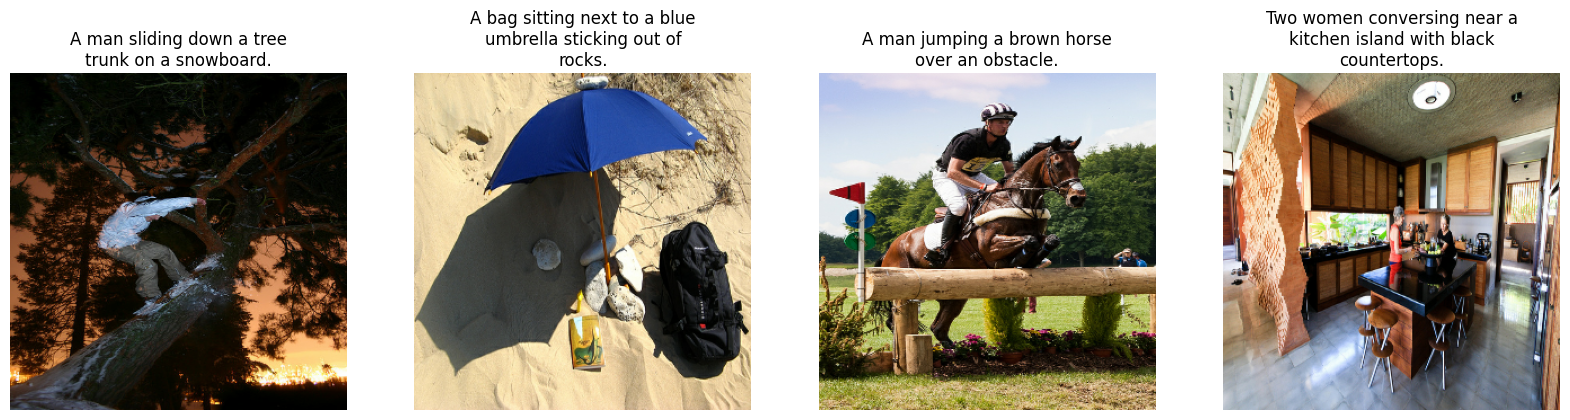

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(train_dataset.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = data["caption"].numpy().decode("utf-8")
    caption = "\n".join(wrap(caption, 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

### Adding '<*start*>' and '<*end*>' tokens to captions
The *add_start_end_tokens* function adds the tokens <*start*> and <*end*> to the beginning and end of the caption, respectively. These tokens help the model understand the beginning and end of each caption sequence.

It's applied to the *train_dataset* using the map method.

In [ ]:
def add_start_end_tokens(data):
    start = tf.convert_to_tensor('<start>')
    end = tf.convert_to_tensor('<end>')
    data['caption'] = tf.strings.join([start, data['caption'], end], separator=' ')

    return data

train_dataset = train_dataset.map(add_start_end_tokens)

In [ ]:
for data in train_dataset.take(4):
    print(data['caption'].numpy().decode("utf-8"))

<start> Busy road in the middle of a very large scale city. <end>
<start> A fluffy animal grazing in a green pasture. <end>
<start> A woman holds a plate of food while she has phone to her ear.   <end>
<start> A passenger bus with name cumfybus drives down a street. <end>


### Tokenization and Text Vectorization

Parameters:
* vocab_size: The maximum number of unique tokens in the vocabulary.
* max_caption_len: The maximum length for each caption sequence to pad or truncate sequences.

Function *standardize* converts the input text to lowercase and removes punctuations.


TextVectorization tokenizer converts text into numerical tokens.
* Sets max_tokens to vocab_size to keep only the most frequent words.
* We will override the default standardization of TextVectorization to preserve "<>" characters.
* Sets output_sequence_length to max_caption_len to pad or truncate sequences.

*tokenizer.adapt* is used to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.

This process takes around 5 minutes.

In [ ]:
vocab_size = 30000
max_caption_len = 21

def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )

tokenizer = TextVectorization(
    max_tokens=vocab_size, # choose the most frequent words from the vocabulary
    standardize=standardize, # remove punctuation
    output_sequence_length=max_caption_len,
)

tokenizer.adapt(train_dataset.map(lambda x: x["caption"]))

In [ ]:
for data in train_dataset.take(4):
    caption = data["caption"].numpy().decode("utf-8")
    print(caption)
    print(tokenizer(caption))

<start> a man in skis is walking up a snowy hill <end>
tf.Tensor(
[  3   2  12   8 145  11  52  41   2 271 231   4   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
<start> table filled with various food dishes and utensils <end>
tf.Tensor(
[  3  25  76   9 322  59 736  10 943   4   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
<start> A woman standing next to a window talking on a cell phone. <end>
tf.Tensor(
[  3   2  22  15  16  13   2 122 268   6   2 179 115   4   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
<start> a close up of a bird standing on a grass field <end>
tf.Tensor(
[  3   2 143  41   5   2 172  15   6   2  62  32   4   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)


### Mapping between Words and Indices using StringLookup layer.
* word_to_index: creates a lookup table to convert words to their corresponding indices in the vocabulary.
* index_to_word: does the reverse, converting indices back to words. Uses the invert=True parameter for this.

In [ ]:
word_to_index = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

### Dataset Preparation for Model Training
Function *create_dataset* takes in a data dictionary with image_tensor and caption, tokenizes the caption and prepares a target tensor by shifting the caption.

In [ ]:
def create_dataset(data):
    image_tensor = data['image_tensor']
    caption_tensor = tokenizer(data['caption'])
    target = tf.concat((caption_tensor[1:], [0]), axis=-1) # next word

    return (image_tensor, caption_tensor), target

batch_size = 32

batched_dataset = (
    train_dataset.map(create_dataset)
    .batch(batch_size, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
for (img, caption), target in batched_dataset.take(1):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Target shape: {target.shape}")
    print(caption[0])
    print(target[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 21)
Target shape: (32, 21)
tf.Tensor(
[  3   2 431 480 171  14   6   2 505   4   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
tf.Tensor(
[  2 431 480 171  14   6   2 505   4   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)


## Model

Let's design an image captioning model.

### Image Encoder

Feature Extractor uses the pre-trained InceptionResNetV2 model to extract features from images. Excludes the top (output) layer and uses pre-trained weights from ImageNet.

InceptionResNetV2 takes (299, 299, 3) image as inputs and return features in (8, 8, 1536) shape

In [ ]:
attention_dim = 512
emb_dim = 128

feature_extr = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights="imagenet")

img_height = 299
img_width = 299
img_channels = 3
features_shape = (8, 8, 1536)

`feature_extr.trainable = False`
freezes the pre-trained InceptionResNetV2 model to prevent its weights from being updated during training.

Reshapes the features to 8x8x1536 for compatibility with the attention mechanism.

Applies a dense layer with ReLU activation to transform the features to have *attention_dim* dimensions.

In [ ]:
feature_extr.trainable = False

img_input = Input(shape=(img_height, img_width, img_channels))
img_features = feature_extr(img_input)

x = Reshape((features_shape[0] * features_shape[1], features_shape[2]))(img_features)
encoder_output = Dense(attention_dim, activation="relu")(x)

In [ ]:
encoder_model = tf.keras.Model(inputs=img_input, outputs=encoder_output)
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 reshape_1 (Reshape)         (None, 64, 1536)          0         
                                                                 
 dense_3 (Dense)             (None, 64, 512)           786944    
                                                                 
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


### Caption Decoder

The inclusion of an attention mechanism allows the model to focus on specific regions of the input image when generating each word in the caption.
Benefit:
This is particularly useful for complex images where different parts of the image may be relevant for different words in the caption.

The GRU (Gated Recurrent Unit) is chosen for its ability to maintain context in sequence data, which is crucial for understanding the semantics of a caption.

The decoder's job is to generate predictions for the next output token.

Decoder Steps:

1. Token Input: The decoder receives a batch of current word tokens (already processed captions up to a certain point) as input.

2. Word Embedding: These tokens are passed through an embedding layer to convert them into dense vectors of fixed size (emb_dim).

3. GRU Processing: The embedded tokens are processed by a GRU layer. The GRU layer maintains an internal state to capture contextual information.

4. Attention Mechanism: The GRU outputs act as the "query" for the attention mechanism. The encoder's output features serve as the "key" and "value" pairs.
The attention layer produces a "context vector" that represents the relevant portions of the image for generating the next word.

5. Combining Context and GRU Output (Skip Connection): The context vector and the GRU output are combined through element-wise addition. This allows the model to incorporate both image and textual context.

6. Layer Normalization: Layer normalization is applied to stabilize the activations and facilitate faster and more stable training.

7. Prediction: The Dense layer at the end transforms the attention-weighted sequence into a probability distribution over the vocabulary.
The most probable next word is selected as the output for this time step.

8. Loop or Terminate: If the end token is predicted or the maximum caption length is reached, the decoder stops. Otherwise, it goes back to step 1, taking the newly predicted word as the next input token.

In [ ]:
caption_input = Input(shape=(max_caption_len), name='words')
emb = Embedding(vocab_size, emb_dim)(caption_input)

gru_decoder = GRU(attention_dim, return_sequences=True, return_state=True)
gru_output, gru_state = gru_decoder(emb)

attention_decoder = Attention()
context_vector = attention_decoder([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

norm_decoder = LayerNormalization(axis=-1)
norm = norm_decoder(addition)

dense_decoder = Dense(vocab_size)
decoder_output = dense_decoder(norm)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 21)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 21, 128)      3840000     ['words[0][0]']                  
                                                                                                  
 gru (GRU)                      [(None, 21, 512),    986112      ['embedding[1][0]']              
                                 (None, 512)]                                                     
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 512)]    0           []                         

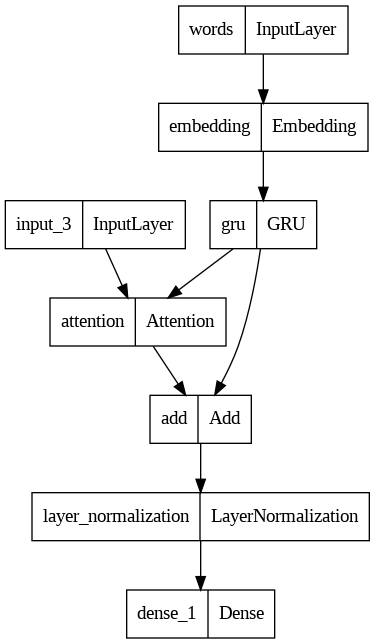

In [ ]:
decoder_model = tf.keras.Model(inputs=[caption_input, encoder_output], outputs=decoder_output)
decoder_model.summary()
tf.keras.utils.plot_model(decoder_model)

### Training

Let's combine encoder and decoder into a model for training.

In [ ]:
train_model = tf.keras.Model(inputs=[img_input, caption_input], outputs=decoder_output)

In [ ]:
train_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 words (InputLayer)             [(None, 21)]         0           []                               
                                                                                                  
 inception_resnet_v2 (Functiona  (None, None, None,   54336736   ['input_6[0][0]']                
 l)                             1536)                                                             
                                                                                            

Loss function:

* Loss Masking: applies a mask to ignore the loss incurred from padding tokens (where the real token value is zero).
* Sentence Length: sums up the mask to find the actual sentence length to correctly scale the loss.
* Mean Loss: computes the mean loss considering only the non-padding tokens.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.not_equal(real, 0)
    mask = tf.cast(mask, dtype=tf.int32)

    sentence_len = tf.reduce_sum(mask) # sum all '1' to get length of the sentence
    mean_loss = tf.reduce_mean(loss_[:sentence_len], 1)

    return mean_loss

In [ ]:
train_model.compile(optimizer="adam", loss=loss_function)

It takes around 15 minutes with NVIDIA T4 GPU to train 1 epoch.

In [ ]:
%%time
train_model.fit(batched_dataset, epochs=1)

2586/2586 [==============================] - 927s 350ms/step - loss: 1.7129
CPU times: user 14min 23s, sys: 1min 15s, total: 15min 39s
Wall time: 15min 33s


## Generate image captioning

### Decoder Prediction Model
* State Initialization:
Unlike the training phase, where the state is automatically reset, here we manually provide an initial state for the GRU. This allows us to have more control over the sequence generation process.
* Layer Reuse:
We reuse the layers trained during the training phase to ensure that the model uses the learned weights for prediction. This is critical for the model to generate meaningful captions. *Add()* layer has no trainable parameters, no need to reuse it.
* Step-by-Step Prediction:
During sampling, the model generates one word at a time. The newly generated word is then fed back into the model to generate subsequent words, unlike the training phase where the entire sequence is processed at once.

In [ ]:
gru_initial_state = Input(shape=(attention_dim), name="gru_initial_state")
gru_output, gru_state = gru_decoder(emb, initial_state=gru_initial_state)
context = attention_decoder([gru_output, encoder_output])
addition = Add()([gru_output, context])
norm = norm_decoder(addition)
decoder_output = dense_decoder(norm)

In [ ]:
decoder_pred_model = tf.keras.Model(inputs=[caption_input, gru_initial_state, encoder_output], outputs=[decoder_output, gru_state])

In [ ]:
decoder_pred_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 21)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 21, 128)      3840000     ['words[0][0]']                  
                                                                                                  
 gru_initial_state (InputLayer)  [(None, 512)]       0           []                               
                                                                                                  
 gru_5 (GRU)                    [(None, 21, 512),    986112      ['embedding_1[1][0]',            
                                 (None, 512)]                     'gru_initial_state[0][0]']

### Caption Generation Loop
* Top-K Sampling:
Instead of picking the most probable next word, the model picks one from the top K probable next words (tf.math.top_k). This introduces randomness and diversity in the generated captions.

* State Update:
The GRU state is updated with each iteration, providing memory to the decoder for generating the next word.

In [ ]:
def captioning(image):
    img = preprocess_image(image)
    features = encoder_model(tf.expand_dims(img, axis=0))
    gru_state = tf.zeros((1, attention_dim))
    input = tf.expand_dims([word_to_index("<start>")], 1)
    caption = []

    for i in range(max_caption_len):
        predictions, gru_state = decoder_pred_model([input, gru_state, features])

        # Choose top K words
        top_probs, top_idxs = tf.math.top_k(input=predictions[0][0], k=10, sorted=False)
        idx = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_idx = top_idxs.numpy()[idx][0]

        caption.append(tokenizer.get_vocabulary()[predicted_idx])

        if predicted_idx == word_to_index('<end>'):
            return caption

        input = tf.expand_dims([predicted_idx], 1)

    return caption

### Test

Let's generate 5 different captions for the same image. This showcases the diversity in the model's captioning ability.

`caption[:-1]` omits the <*end*> token.

a couple of soccer players are playing on top of a field.
a couple of women playing games a soccer ball.
a soccer player is trying to get a ball and a soccer ball.
a young boy playing with a soccer ball.
two girls play in the air with a soccer ball on him.


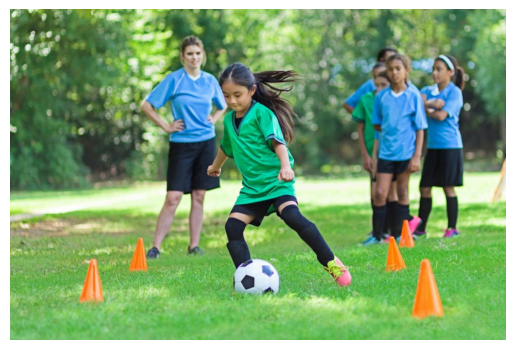

In [ ]:
filename = "sample_images/sport.jpg"
img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=img_channels)
plt.imshow(img)
plt.axis("off")

for i in range(5):
    caption = captioning(img)
    print(" ".join(caption[:-1]) + ".")